# Mads notebook: General model inversion problem

## Problem setup

Import Mads

In [1]:
import Mads

┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/vvv/.julia/packages/PyPlot/XHEG0/src/init.jl:118


Create a problem dictionary:

In [2]:
md = Dict()

Dict{Any, Any}()

Setup model parameters:

In [3]:
md["Parameters"] = Mads.createparameters([1,1,1,1]; key=["a", "b", "c", "n"], dist=["Uniform(-10, 10)", "Uniform(-10, 10)", "Uniform(-5, 5)", "Uniform(-3, 3)"])

OrderedCollections.OrderedDict{Any, Any} with 4 entries:
  "a" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "b" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "c" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "n" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …

There are 4 model parameters (`a`, `b`, `c`, and `n`). The initial values and the prior distributions of the parameters are defined for each parameter.

In [4]:
md["Observations"] = Mads.createobservations([0,1.1,1.9,3.1,3.9,5]; weight=[100,100,100,100,10,0], time=[0,1,2,3,4,5], dist=["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"])

dist = ["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"]


OrderedCollections.OrderedDict{Any, Any} with 6 entries:
  "o1" => OrderedCollections.OrderedDict{String, Any}("target"=>0.0, "weight"=>…
  "o2" => OrderedCollections.OrderedDict{String, Any}("target"=>1.1, "weight"=>…
  "o3" => OrderedCollections.OrderedDict{String, Any}("target"=>1.9, "weight"=>…
  "o4" => OrderedCollections.OrderedDict{String, Any}("target"=>3.1, "weight"=>…
  "o5" => OrderedCollections.OrderedDict{String, Any}("target"=>3.9, "weight"=>…
  "o6" => OrderedCollections.OrderedDict{String, Any}("target"=>5.0, "weight"=>…

There are 6 observations (`o1`, `o2`, `o3`, ... and `o6`). The calibration targets, observation weights (i.e., inverse of measurement standard deviations), and acceptable ranges are defined for each observation.

A function (called `polynominal`) is defined to compute the 6 observations given 4 parameters as an input:

In [5]:
function polynominal(parameters::AbstractVector)
	f(t) = parameters[1] * (t ^ parameters[4]) + parameters[2] * t + parameters[3] # a * t^n + b * t + c
	predictions = map(f, 0:5)
	return predictions
end

polynominal (generic function with 1 method)

The function is setup now in the `md` dictionary as a function that will be applied to perform model simulation:

In [7]:
Mads.setmodel!(md, polynominal)

(::Mads.var"#madscommandfunctionwithexpressions#18") (generic function with 1 method)

In [8]:
display(md)

Dict{Any, Any} with 3 entries:
  "Julia function" => polynominal
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("a"=>OrderedColl…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…

Now the problem is setup!

## Forward model simulation

A single forward model run based on the initial model parameters cane be executed as follows:

In [9]:
Mads.forward(md)

OrderedCollections.OrderedDict{Any, Float64} with 6 entries:
  "o1" => 1.0
  "o2" => 3.0
  "o3" => 5.0
  "o4" => 7.0
  "o5" => 9.0
  "o6" => 11.0

The forward model run can be also executed using the following command (not recommended):

In [10]:
polynominal(Mads.getparamsinit(md))

6-element Vector{Float64}:
  1.0
  3.0
  5.0
  7.0
  9.0
 11.0

The initial model predctions can be plotted as well:

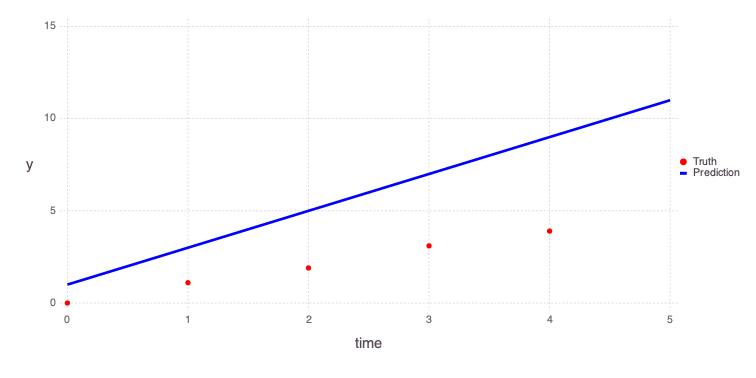

In [11]:
Mads.plotmatches(md)

The figure above shows that the `true` observations are not well reproduced by the model using the initial model parameter guesses.

## Model calibration (inversion)

The calibation (inversion) of the developed model is achieved using the following command:

In [12]:
calib_param, calib_result = Mads.calibrate(md)

(OrderedCollections.OrderedDict("a" => 0.48652749043975874, "b" => 0.48653799120462793, "c" => -0.001625793681175658, "n" => 1.0209744172380697), OptimBase.MultivariateOptimizationResults{LsqFit.LevenbergMarquardt, Float64, 1}(LsqFit.LevenbergMarquardt(), [0.10016742116155988, 0.10016742116155988, 0.20135792079033074, 0.33983690945412187], [0.04867196375755519, 0.04867301507909251, -0.00032515874196489825, 0.3472623008114141], 420.3001214282925, 5, false, true, 0.0001, 0.0, false, 0.001, 0.0, false, 1.0e-6, 0.0, false, Iter     Function value   Gradient norm 
------   --------------   --------------
, 71, 5, 0))

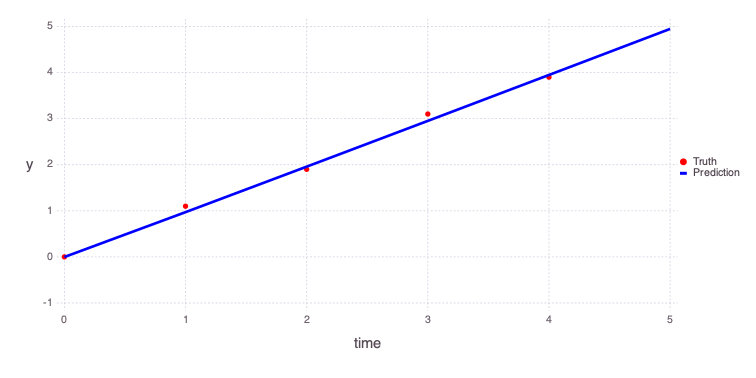

In [13]:
Mads.plotmatches(md, calib_param)

Initial values of the model parameters are:

In [14]:
Mads.showparameterestimates(md)

a =               1 distribution = Uniform(-10, 10) 
b =               1 distribution = Uniform(-10, 10) 
c =               1 distribution = Uniform(-5, 5) 
n =               1 distribution = Uniform(-3, 3) 
Number of optimizable parameters: 4


Estimated values of the model parameters based on the model calibration (inversion) are:

In [15]:
Mads.showparameterestimates(md, calib_param)

a =        0.486527 distribution = Uniform(-10, 10) 
b =        0.486538 distribution = Uniform(-10, 10) 
c =     -0.00162579 distribution = Uniform(-5, 5) 
n =         1.02097 distribution = Uniform(-3, 3) 
Number of optimizable parameters: 4


## Evaluation of posterior uncertainties

In [16]:
chain, llhoods = Mads.emceesampling(md; numwalkers=10, nsteps=100000, burnin=10000, thinning=10, seed=2016, sigma=0.01)

([-0.13601651918047325 6.449935308058958 … -1.627391800717899 -4.119922628004796; 1.0941690654040885 -5.395383966755342 … 2.6762188920693237 5.204364898549472; 0.025560758321624525 0.006156717419079649 … 0.021233373376607138 -0.09250682198195176; 0.7802369379764128 0.9898140312646484 … 1.0448023602658587 1.0118196568255122], [-13.51498779106448, -13.925503638604303, -13.826975926071242, -13.894444579001128, -14.60816852023264, -13.579594236934511, -14.837837586690735, -14.240383157619835, -14.939965000345335, -13.311376267487034  …  -15.994667889684084, -14.595653814274797, -15.207147995830884, -14.278745223592924, -17.31793585314554, -13.304730171203236, -14.289486110117714, -14.503231489805287, -14.862344300487429, -14.35637958798673])

In [17]:
f = Mads.forward(md, chain)

6×10000 Matrix{Float64}:
 0.0255608  0.00615672  0.0482318  …  -0.0541153  0.0212334  -0.0925068
 0.983713   1.06071     0.992987       1.05046    1.07006     0.991935
 1.9803     2.0245      1.97412        2.09271    2.01623     2.00859
 2.98754    2.95449     2.967          3.07744    2.9214      2.99928
 4.00106    3.86261     3.96712        4.00702    3.79942     3.97301
 5.01893    4.75453     4.97245    …   4.88306    4.65697     4.93409

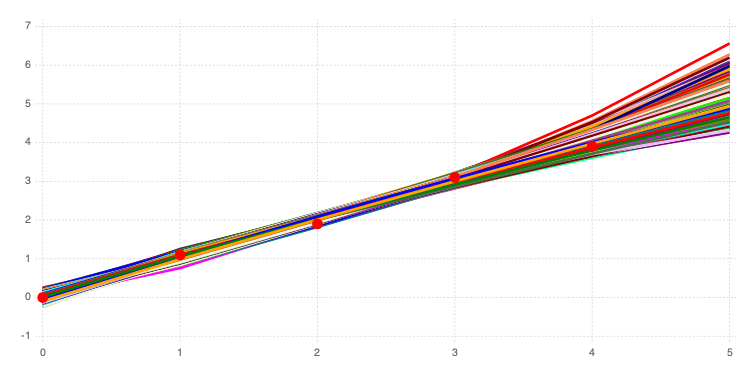

In [18]:
Mads.spaghettiplot(md, f)

In [22]:
Mads.scatterplotsamples(md, permutedims(chain), "emcee_scatter.png")

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1317


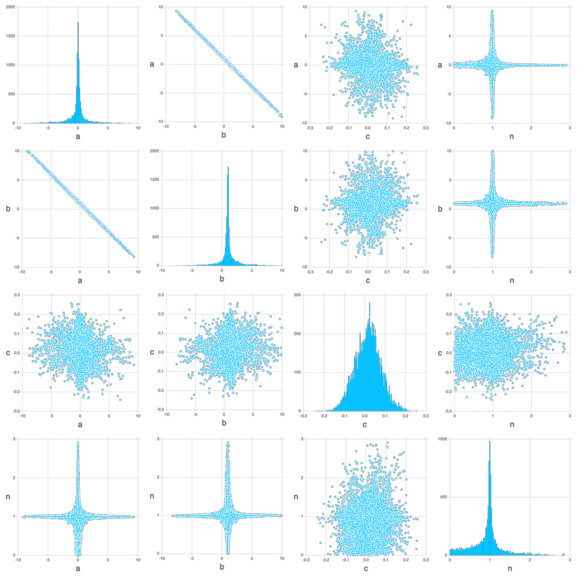

LoadError: UndefVarError: trytoopen not defined

In [23]:
Mads.display("emcee_scatter.png")